In [49]:
import torch
import torch.nn as nn
import math
import random

In [91]:
class RNN(nn.Module):
    def __init__(self, x_dim, hidden_dim, output_dim) -> None:
        super().__init__()
        self.x_dim = x_dim
        self.hidden_dim = hidden_dim
        self.output_dim = output_dim
        self.w_hx = nn.Parameter(torch.randn(size=(x_dim, hidden_dim)))
        self.b_h = nn.Parameter(torch.randn(size=(hidden_dim,)))
        self.w_hh = nn.Parameter(torch.randn(size=(hidden_dim, hidden_dim)))
        self.w_qh = nn.Parameter(torch.randn(size=(hidden_dim, output_dim))) 
        self.b_q = nn.Parameter(torch.randn((output_dim,)))       
        self.hidden_state = None
        self.hidden_state_pre = None

    def init(self, batch_size):
        self.hidden_state = torch.zeros(size=(batch_size, self.hidden_dim))

    def forward(self, X):
        self.hidden_state = torch.matmul(self.hidden_state, self.w_hh) + torch.matmul(X, self.w_hx) + self.b_h
        self.hidden_state = torch.tanh(self.hidden_state)
        Y = torch.matmul(self.hidden_state, self.w_qh) + self.b_q
        Y = torch.tanh(Y)
        return Y

    def warm_up(self, X):
        for j in range(X.shape[1]):
            self.forward(X[:,j])
    
    @classmethod
    def generate_sample(cls, amount, sequence_length, func):
        x = []
        for i in range(amount):
            r = random.random() + random.random() + random.random()
            x.append([r + 0.1 * t for t in range(sequence_length)])

        y = []
        for i in range(amount):
            y.append([func(t) for t in x[i]])    

        x = torch.Tensor(x)
        y = torch.Tensor(y)        
        x = x.reshape([x.shape[0], x.shape[1], 1])
        y = y.reshape([y.shape[0], y.shape[1], 1])
        return x, y

In [92]:
torch.autograd.set_detect_anomaly(True)
torch.set_printoptions(profile="full")

def gradient_clip(net: nn.Module, theta):
    params = [p for p in net.parameters() if p.requires_grad]
    norm = torch.sqrt(sum(torch.sum((p.grad ** 2)) for p in params))
    if norm > theta:
        for param in params:
            param.grad[:] *= theta / norm

def train(rnn: RNN, X_data, Y_data, batch_size, train_step = 1):
    # data shape, [batch_size, sequence_length, dim]
    # we are trying to the 50th elememt using the first 49 elements
    assert X_data.shape == Y_data.shape
    assert X_data.shape[1] > 50
    amount = X_data.shape[0]
    optimizer = torch.optim.Adam(rnn.parameters(), lr=0.01)
    mse = nn.MSELoss()
    for i in range((amount + batch_size - 1) // batch_size)[1:]:
        Y_label = Y_data[(i - 1) * batch_size : min(amount, i * batch_size)]
        rnn.init(batch_size)
        Y = None
        loss = torch.zeros(())
        for j in range(0, 0):
            Y = rnn(Y_label[:, j])
        for j in range(0, 49):
            Y = rnn(Y_label[:, j])
            loss += mse(Y, Y_label[:, j + 1])
        optimizer.zero_grad()
        print(loss, Y[0], Y_label[0, 49])
        loss.backward()
        optimizer.step()
        rnn.hidden_state.detach_()

# Training
rnn = RNN(1, 5, 1)
for i in range(100):
    amount = 100
    sequence_length = 60
    X_data, Y_data = RNN.generate_sample(amount, sequence_length, math.sin)
    train(rnn, X_data, Y_data, 10)

tensor(27.7795, grad_fn=<AddBackward0>) tensor([-0.3588], grad_fn=<SelectBackward>) tensor([-0.7234])
tensor(27.0129, grad_fn=<AddBackward0>) tensor([0.3392], grad_fn=<SelectBackward>) tensor([0.9498])
tensor(22.4258, grad_fn=<AddBackward0>) tensor([-0.8266], grad_fn=<SelectBackward>) tensor([0.3051])
tensor(21.2907, grad_fn=<AddBackward0>) tensor([-0.5559], grad_fn=<SelectBackward>) tensor([-0.0954])
tensor(20.2467, grad_fn=<AddBackward0>) tensor([-0.8611], grad_fn=<SelectBackward>) tensor([0.4299])
tensor(18.2974, grad_fn=<AddBackward0>) tensor([-0.9616], grad_fn=<SelectBackward>) tensor([-0.2210])
tensor(15.9246, grad_fn=<AddBackward0>) tensor([-0.5233], grad_fn=<SelectBackward>) tensor([-0.3412])
tensor(15.2215, grad_fn=<AddBackward0>) tensor([-0.7726], grad_fn=<SelectBackward>) tensor([0.2823])
tensor(13.6551, grad_fn=<AddBackward0>) tensor([-0.5402], grad_fn=<SelectBackward>) tensor([-0.0470])
tensor(13.3894, grad_fn=<AddBackward0>) tensor([-0.4415], grad_fn=<SelectBackward>) ten

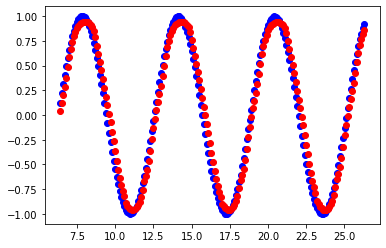

In [94]:
# Inference
X_data, Y_data = RNN.generate_sample(1, 500, math.sin)
y_inf = []
for i in range(200):
    rnn.init(1)
    for j in range(49):
        y = rnn(Y_data[:, i + j])
    y_inf.append(y[0].detach().numpy()[0])
from matplotlib import pyplot

X_show = X_data[0, 50:250].numpy()
Y_show = Y_data[0, 50:250].numpy()

pyplot.scatter(X_show, Y_show, c="blue")
pyplot.scatter(X_show, y_inf, c="red")
pyplot.show()

import torch
import torch.nn as nn
import math
import random


def generate_sample(amount, sequence_length, hidden_out, func):
    X = []
    for i in range(amount):
        r = random.random()
        X.append([r + 0.1 * t + 0.01 * i for t in range(sequence_length)])

    Y = []
    for i in range(amount):
        Y.append([func(t) for t in X[i]])    

    X = torch.Tensor(X)
    Y = torch.Tensor(Y)        
    X = X.reshape([X.shape[0], X.shape[1], 1])
    Y = Y.reshape([Y.shape[0], Y.shape[1], 1])
    hidden = torch.zeros([1, amount, hidden_out])
    return X, Y, hidden

x, y, hidden = generate_sample(1, 1000, 5, math.sin)
print("X: ", x)
print("Y: ", y)

In [127]:
print(x.shape, y.shape)

class RNN(nn.Module):
    def __init__(self) -> None:
        super().__init__()
        self.rnn = nn.RNN(input_size=1, hidden_size=5, batch_first=True)
        self.linear = nn.Linear(in_features=5, out_features=1, bias=True)

    def forward(self, x, hidden_state):
        y, _ = self.rnn(x, hidden_state)
        y = self.linear(y)
        return y

rnn = RNN()

print(rnn.parameters())

def train():
    optimizer = torch.optim.Adam(rnn.parameters(), lr=0.01)
    for i in range(2000):
        train_x, train_y, hidden = generate_sample(10, 50, 5, math.sin)
        # print(train_x.shape, train_y.shape, hidden.shape)
        y_hat = rnn(train_y[:, :49, :], hidden)
        # print(y_hat.shape)
        mse = nn.MSELoss()
        loss = mse(train_y[:, 1:, :], y_hat)
        print(loss)
        rnn.zero_grad()
        loss.backward()
        optimizer.step()
train()

torch.Size([1, 1000, 1]) torch.Size([1, 1000, 1])
<generator object Module.parameters at 0x000001D7719AADD0>
tensor(1.1575, grad_fn=<MseLossBackward>)
tensor(1.0062, grad_fn=<MseLossBackward>)
tensor(0.9098, grad_fn=<MseLossBackward>)
tensor(0.7951, grad_fn=<MseLossBackward>)
tensor(0.6893, grad_fn=<MseLossBackward>)
tensor(0.6450, grad_fn=<MseLossBackward>)
tensor(0.5679, grad_fn=<MseLossBackward>)
tensor(0.4957, grad_fn=<MseLossBackward>)
tensor(0.4220, grad_fn=<MseLossBackward>)
tensor(0.3772, grad_fn=<MseLossBackward>)
tensor(0.3529, grad_fn=<MseLossBackward>)
tensor(0.2809, grad_fn=<MseLossBackward>)
tensor(0.2691, grad_fn=<MseLossBackward>)
tensor(0.2431, grad_fn=<MseLossBackward>)
tensor(0.2154, grad_fn=<MseLossBackward>)
tensor(0.1988, grad_fn=<MseLossBackward>)
tensor(0.1810, grad_fn=<MseLossBackward>)
tensor(0.1625, grad_fn=<MseLossBackward>)
tensor(0.1494, grad_fn=<MseLossBackward>)
tensor(0.1342, grad_fn=<MseLossBackward>)
tensor(0.1197, grad_fn=<MseLossBackward>)
tensor(0.

torch.Size([1, 1000, 1]) torch.Size([1, 1000, 1])
tensor(10.2786) tensor(-0.8439)
y_inference shape torch.Size([1, 49, 1])
hidden shape torch.Size([1, 1, 5])
tensor([[-0.8911]], grad_fn=<SelectBackward>)
x.shape (500, 1)
y inference shape 500


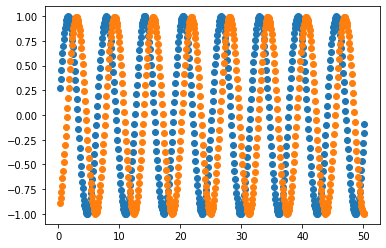

In [128]:
x, y, hidden = generate_sample(1, 1000, 5, math.sin)
print(x.shape, y.shape)
print(x[0, 100, 0], y[0, 50, 0])
y_inference = rnn(y[0:, 0:49, :], hidden)
print("y_inference shape", y_inference.shape)
print("hidden shape", hidden_out.shape)
print(y_inference[0:1, -1])
y_inference = []
for i in range(500):
    t = rnn(y[0:, 0 + i: 49 + i, :], hidden)
    y_inference.append(t[0, -1, 0].detach().numpy())

x = x[0, 0:500, :].detach().numpy()
y = y[0, 0:500, :].detach().numpy()
print("x.shape", x.shape)
print("y inference shape", len(y_inference))
from matplotlib import pyplot
pyplot.scatter(x, y)
pyplot.scatter(x, y_inference)
pyplot.show()


# print("y_inference", y_inference)
# print(y_inference[0][100][0])